__File: src_physics_from_operator_evolution.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jun 23, 2020__

Add brief description here.

In [1]:
from os import chdir, getcwd
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# Scripts made by A.T.
from Figures import figures_functions as ff
import observables as ob
import operators as op
from Potentials.vsrg_macos import load_save_potentials as lsp
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

In [2]:
# Current working directory
cwd = getcwd()

# Specifications for potential and SRG evolution

# AV18
kvnn = 6
# Details of the momentum mesh (might want to change this)
kmax = 10.0
kmid = 2.0
ntot = 120

# Load momentum and weights (channel argument doesn't matter here)
k_array, k_weights = lsp.load_momentum(kvnn, '1S0', kmax, kmid, ntot)
# Divide out momenta/weights with factor_array
factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
row, col = np.meshgrid(factor_array, factor_array)
# Same thing but for coupled-channel
factor_array_cc = np.concatenate( (factor_array, factor_array) )
row_cc, col_cc = np.meshgrid(factor_array_cc, factor_array_cc)


# SRG details
generator = 'Wegner'
lamb = 1.0 # 240 MeV

# Momentum values for q_0 and q_i
#q_points = np.array([2.0, 2.5, 3.0, 4.0])
q_points = np.array([2.0, 4.0, 6.0, 8.0, 9.0])
# q_points = np.array([1.95, 2.0, 2.1])

In [3]:
# Main calculation

# Load initial and evolved Hamiltonians [MeV], and SRG transformations
# 1S0
H_initial_1s0 = lsp.load_hamiltonian(kvnn, '1S0', kmax, kmid, ntot)
H_evolved_1s0 = lsp.load_hamiltonian(kvnn, '1S0', kmax, kmid, ntot, method='srg', generator=generator, lamb=lamb)
U_matrix_1s0 = SRG_unitary_transformation(H_initial_1s0, H_evolved_1s0) / row / col
# 3S1
H_initial_3s1 = lsp.load_hamiltonian(kvnn, '3S1', kmax, kmid, ntot)
H_evolved_3s1 = lsp.load_hamiltonian(kvnn, '3S1', kmax, kmid, ntot, method='srg', generator=generator, lamb=lamb)
U_matrix_3s1 = SRG_unitary_transformation(H_initial_3s1, H_evolved_3s1) / row_cc / col_cc

# Store results in dictionary where q_i values are the keys
d = {}

# Loop over q_i values
for q_i in q_points:
    
    d[q_i] = {}
    
    # Take ratios of U(k,q_i)_1S0 / U(k,q_i)_3S1 at k < \lambda << q_i
    q_i_index = op.find_q_index(q_i, k_array)
    numerator_array = U_matrix_3s1[:ntot, q_i_index] * U_matrix_3s1.T[q_i_index, :ntot] + \
                      U_matrix_3s1[:ntot, ntot+q_i_index] * U_matrix_3s1.T[ntot+q_i_index, :ntot]
    denominator_array = U_matrix_1s0[:ntot, q_i_index] * U_matrix_1s0.T[q_i_index, :ntot]
#     numerator_array = U_matrix_3s1[:ntot, q_i_index] * U_matrix_3s1[:ntot, q_i_index].T + \
#                       U_matrix_3s1[:ntot, ntot+q_i_index] * U_matrix_3s1[:ntot, ntot+q_i_index].T
#     denominator_array = U_matrix_1s0[:ntot, q_i_index] * U_matrix_1s0[:ntot, q_i_index].T
        
    # Store ratio in dictionary
    d[q_i] = abs( numerator_array / denominator_array )
#     d[q_i]['num'] = numerator_array
#     d[q_i]['den'] = denominator_array

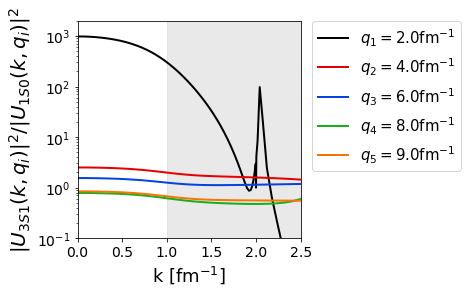

In [4]:
# Plot ratios |U(k,q_i)/U(k,q_0)|


# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)
    
# Axes limits
xlim = [0.0, 2.5]
ylim = [1e-1, 2e3]
# ylim = [-0.001, 0.01]
        
# Axes labels and fontsize
x_label = 'k [fm' + r'$^{-1}$' + ']'
x_label_size = 18
y_label = r'$|U_{3S1}(k,q_i)|^2/|U_{1S0}(k,q_i)|^2$'
# y_label = r'$|U_{3S1}(k,q_i)|^2$'
# y_label = r'$|U_{1S0}(k,q_i)|^2$'
y_label_size = 20
axes_tick_size = 14
    
# Curve width
curve_width = 2.0

# Subplot labels
legend_size = 15
legend_location = 'upper left'
    
# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

# Loop over channels and keep track of channels index
for i, q_i in enumerate(q_points):
        
    # Curve color, styles, and labels
    curve_color = ff.xkcd_colors(i)
    curve_style = ff.line_styles(i)
    curve_label = r'$q_%d=%.1f$' % (i+1, q_i) + 'fm' + r'$^{-1}$'
#     curve_label = r'$q_%d=%.2f$' % (i+1, q_i) + 'fm' + r'$^{-1}$'
        
    # Add curve to figure
    ax.semilogy(k_array, d[q_i], color=curve_color, label=curve_label, linestyle='solid', linewidth=curve_width)
#     ax.plot(k_array, d[q_i]['num'], color=curve_color, label=curve_label, linestyle='solid',
#             linewidth=curve_width)
#     ax.plot(k_array, d[q_i]['den'], color=curve_color, label=curve_label, linestyle='solid',
#             linewidth=curve_width)
        
# Shade gray from 0 to \lambda or \Lambda_BD value on plot
ax.fill_betweenx(ylim, lamb, k_array[-1], edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)

# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
    
# Set axes labels, legend, and anchored text labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)
ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)
    
# Enlarge axes tick marks
ax.tick_params(labelsize=axes_tick_size)

# Save figure
file_name = 'transformation_ratios_kvnn%d_%s_qpoints' % (kvnn, generator)
# file_name = 'transformation_3S1_kvnn%d_%s_qpoints' % (kvnn, generator)
# file_name = 'transformation_1S0_kvnn%d_%s_qpoints' % (kvnn, generator)
for q_i in q_points:
    file_name += '_%.1f' % q_i
chdir('Figures/SRC_physics')
f.savefig(file_name + '.pdf', bbox_inches='tight')
chdir(cwd)

In [5]:
# psi_evolved = ob.wave_function(H_evolved_3s1)
# psi_initial = ob.wave_function(H_initial_3s1)

# u_evolved = psi_evolved[:ntot] / factor_array
# w_evolved = psi_evolved[ntot:] / factor_array
# u_initial = psi_initial[:ntot] / factor_array
# w_initial = psi_initial[ntot:] / factor_array

# plt.semilogy(k_array, u_evolved**2, label='u_f(k)')
# plt.semilogy(k_array, w_evolved**2, label='w_f(k)')
# plt.semilogy(k_array, u_initial**2, label='u_i(k)')
# plt.semilogy(k_array, w_initial**2, label='w_i(k)')
# plt.legend()
# plt.ylim([1e-6, 1e3])
# plt.xlim([0,6])

In [6]:
def momentum_projection_integrand_contours_full(q, kvnn, generator, lamb, eps=-2.22):

    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1'
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result (need to double the size for coupled-channel)
    factor_array = np.concatenate( (np.sqrt(k_weights), np.sqrt(k_weights)) )
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Size of figure
    row_number = 2
    col_number = 2
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    axes_max = 4.0
    axes_lim = [0.0, axes_max]
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ['%d' % tick for tick in axes_ticks]
    axes_tick_size = 18
        
    # Colorbar ticks, label, and fontsize
    mx = -3
    mn = -8
    levels_number = 61
    levels = np.logspace(mn, mx, levels_number)
    levels_ticks = np.logspace(mn, mx, mx-mn+1)
    levels_ticks_strings = [r'$10^{%d}$' % step for step in range(mn, mx+1)]
    colorbar_norm = colors.LogNorm(vmin=mn, vmax=mx)
    colorbar_label = '[fm' + r'$^5$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    color_style = 'Blues'
        

    # --- Load operators --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Load unitary transformation
    # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
    if generator == 'Block-diag':
        H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0, lambda_bd=lamb)
    else:
        H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
    # Evolved momentum projection operator
    operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix, smeared=False)
#     operator = op.momentum_projection_operator(q, k_array, k_weights, channel, smeared=False)
            
    # Load evolved wave functions and divide out momentum and weights
#     psi = ob.wave_function(H_initial, eps)
    psi = ob.wave_function(H_initial, eps, U=U_matrix)
    
    # TESTING
    ss_cont = abs( psi.T[:ntot] @ operator[:ntot, :ntot] @ psi[:ntot] )
    sd_cont = abs( psi.T[:ntot] @ operator[:ntot, ntot:] @ psi[ntot:] )
    ds_cont = abs( psi.T[ntot:] @ operator[ntot:, :ntot] @ psi[:ntot] )
    dd_cont = abs( psi.T[ntot:] @ operator[ntot:, ntot:] @ psi[ntot:] )
    total = ss_cont+sd_cont+ds_cont+dd_cont
    print(ss_cont/total*100)
    print(sd_cont/total*100)
    print(ds_cont/total*100)
    print(dd_cont/total*100)
    
    # Mesh-grids of psi
    psi_row, psi_col = np.meshgrid(psi / factor_array, psi / factor_array)
        
    # Matrix elements of < psi | a^dagger_q a_q | psi >
    integrand = psi_row * (operator / row / col) * psi_col
    # Re-size
    integrand_ss = abs(integrand[:ntot, :ntot])
    integrand_sd = abs(integrand[:ntot, ntot:])
    integrand_ds = abs(integrand[ntot:, :ntot])
    integrand_dd = abs(integrand[ntot:, ntot:])
            
    # Interpolate the integrand through 0 to axes_max for smoother looking figure (the extension _int means 
    # interpolated)
    k_array_int, integrand_ss_int = ff.interpolate_matrix(k_array, integrand_ss, axes_max+0.2)
    k_array_int, integrand_sd_int = ff.interpolate_matrix(k_array, integrand_sd, axes_max+0.2)
    k_array_int, integrand_ds_int = ff.interpolate_matrix(k_array, integrand_ds, axes_max+0.2)
    k_array_int, integrand_dd_int = ff.interpolate_matrix(k_array, integrand_dd, axes_max+0.2)

    # Store in dictionary with generator and lamb as keys
    d['ss'] = integrand_ss_int
    d['sd'] = integrand_sd_int
    d['ds'] = integrand_ds_int
    d['dd'] = integrand_dd_int
    
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, char_i in enumerate(['s', 'd']):
        for j, char_j in enumerate(['s', 'd']):
            
            cc = char_i + char_j
            
            c = axs[i, j].contourf(k_array_int, k_array_int, d[cc], levels, norm=colors.LogNorm(),
                                   cmap=color_style, extend='both')
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [7]:
# # Contours of momentum projection operator integrand with deuteron wave function using transformations from AV18

# q = 2.0
# kvnn = 6
# lamb = 1.2

# f, axs = momentum_projection_integrand_contours_full(q, kvnn, generator, lamb, eps=-2.22)

# label_size = 20
# label_location = 'lower right'
# for i, char_i in enumerate(['S', 'D']):
#     for j, char_j in enumerate(['S', 'D']):
#         label = r'$^3{\rm %s}_1$' % char_i + '-' + r'$^3{\rm %s}_1$' % char_j
#         anchored_text = AnchoredText(label, frameon=False, loc=label_location, prop=dict(size=label_size))
#         axs[i, j].add_artist(anchored_text)

# file_name = 'deuteron_dist_contributions.png'
# chdir('Figures/SRC_physics')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)